In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc
import sklearn

In [2]:
#
# Define paths to pickle files
# Defining functions
#

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')
ROOT2 = ROOT # 'pickle_jar/'#

# define lists of temperature
temperature_list = ['292.0', '200.0', '100.0']
c_list = ['Lxy1e1', "Lxy2e1"] #

seed_free_256 = [2928, 82, 1008] # seed for free field case, the order match temperature_list
seed_cave_256z = [100810,100120] # seed for cavity field case, the order match c_list
seed_cave_512z = [512100110,512100120] # seed for cavity field case, the order match c_list
seed_cave_256b = [8100110, 8100120]
seed_cave_512b = [8512110, 8512120]

# define patterns of paths that lead to pickle file
freefield_256_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
cavityfield_256z_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_512z_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_256b_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_512b_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_256_path(temp, seed_free_256[i]))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256z_path('100.0', seed_cave_256z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512z_path('100.0', seed_cave_512z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256b_path('100.0', seed_cave_256b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512b_path('100.0', seed_cave_512b[i], c))
    
fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

FREEFIELD_RESULT_256_DICT = { # result in free field path
    temp: freefield_256_path(temp,seed_free_256[i])
    for i, temp in enumerate(temperature_list)
}
CAVITYFIELD_RESULT_256z_DICT = { # result in cavity field path
    c: cavityfield_256z_path('100.0',seed_cave_256z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512z_DICT = { # result in cavity field path
    c: cavityfield_512z_path('100.0',seed_cave_512z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_256b_DICT = { # result in cavity field path
    c: cavityfield_256b_path('100.0',seed_cave_256b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512b_DICT = { # result in cavity field path
    c: cavityfield_512b_path('100.0',seed_cave_512b[i], c)
    for i, c in enumerate(c_list)
}

def getall_colliding_time(result_dict_path, limit = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])

    n_pickle = 0
    for i, (j, path) in enumerate(directory_dict.items()):
        if limit and n_pickle >= limit: 
            break

        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue
            
        atoms = result_dict['atoms']
        
        time = get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])

        del result_dict
        n_pickle += 1
        
    return all_colliding_time


/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


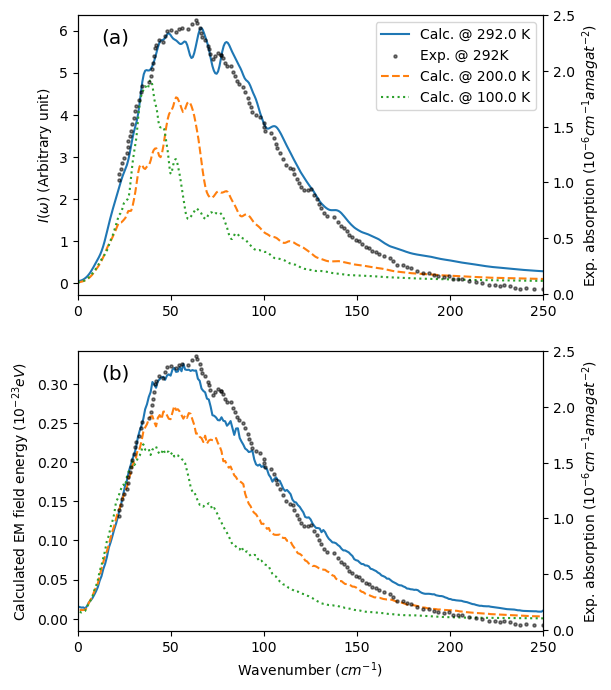

In [3]:
## from copy import deepcopy

fig,ax = plt.subplots(2, figsize = (6,8))

for i in [0,1]:
    # plotting the experimental dataset
    tax = ax[i].twinx()
    exp_data = pd.read_csv('data/plot-data.csv')
    tax.scatter(
        exp_data.loc[:,'x'],
        exp_data.loc[:,' y'],
        s = 5, alpha = 0.5, c = 'black', 
        label = 'Exp. @ 292K' if i == 0 else None
    )
    tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')
    tax.set_ylim(-0.01,2.5)

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_256_DICT.items()):
    
    dipole_spec = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        dipole_spec.add_result_dict(freefield_result_dict)
          
        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        del freefield_result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e23
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    ax[1].plot(o, f, label = "Calc. @ {} K".format(temp), linestyle = linestyle_list[i])
    # to here for rad profile - end of copy

    w, spec = dipole_spec()
    spec = np.mean(spec, axis = 0)
    spec *= 1e5
    spec = spec[ w < 300 ]
    w = w[w < 300]
    # to here for dipole spectra - end of copying
    
    ax[0].plot(w, spec, linestyle = linestyle_list[i], label = "Calc. @ {} K".format(temp)) 
    
    if temp == '100.0':
        rad_profile100 = f
        omega_profile100 = o

    if i == 0:
        ax[0].scatter([], [], s = 5, alpha = 0.5, c = 'black', 
        label = 'Exp. @ 292K') 
    
ax[0].legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax[0].set_xlim(0,250)
ax[1].set_xlim(0,250)
#ax[0].set_ylim(-0.01,6.7)
#ax[1].set_ylim(-0.01,1.08)
ax[0].set_ylabel(r"$I(\omega)$ (Arbitrary unit)")
ax[1].set_ylabel(r"Calculated EM field energy $(10^{-23} eV)$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.05,0.9), xycoords = 'axes fraction',fontsize = 'x-large')
ax[1].annotate('(b)',xy = (0.05,0.9), xycoords = 'axes fraction',fontsize = 'x-large')

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

In [5]:
for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_512b_DICT.items()):
    print(temp)

    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile = []
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        field = result_dict['field']
        
        print(j, np.sum(field.history['energy'][-1]))

Lxy1e1
16 (444.67750618543107+0j)
17 (462.4524187838357+0j)
15 (453.31820438355004+0j)
14 (476.8041038091081+0j)
10 (446.61587116462414+0j)
11 (409.13633866828434+0j)
13 (438.14941068399554+0j)
9 (457.0115973268531+0j)
8 (470.8735137357829+0j)
12 (421.96418819457983+0j)
5 (443.7537546197145+0j)
4 (435.53604766938776+0j)
6 (460.9226832164214+0j)
20 (nan+nanj)
7 (437.6471303342572+0j)
3 (410.0537309769048+0j)
19 (487.6497108913261+0j)
18 (475.8579806115392+0j)
2 (450.19934760320166+0j)
0 (436.3106467026619+0j)
1 (424.24191309375493+0j)
Lxy2e1
16 (433.02380073106565+0j)
17 (454.5222496568772+0j)
15 (499.6518552222101+0j)
14 (482.1197930604096+0j)
10 (452.8354386023674+0j)
11 (490.7341307317405+0j)
13 (457.5834881172701+0j)
9 (444.38298838139036+0j)
8 (464.9324279302625+0j)
12 (455.18012961957743+0j)
5 (425.12681360510487+0j)
4 (441.78507134323695+0j)
6 (456.511947913414+0j)
7 (461.98787424276964+0j)
3 (487.8454015613201+0j)
19 (450.6697567721292+0j)
18 (461.2131587010713+0j)
2 (435.828592

/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


32260

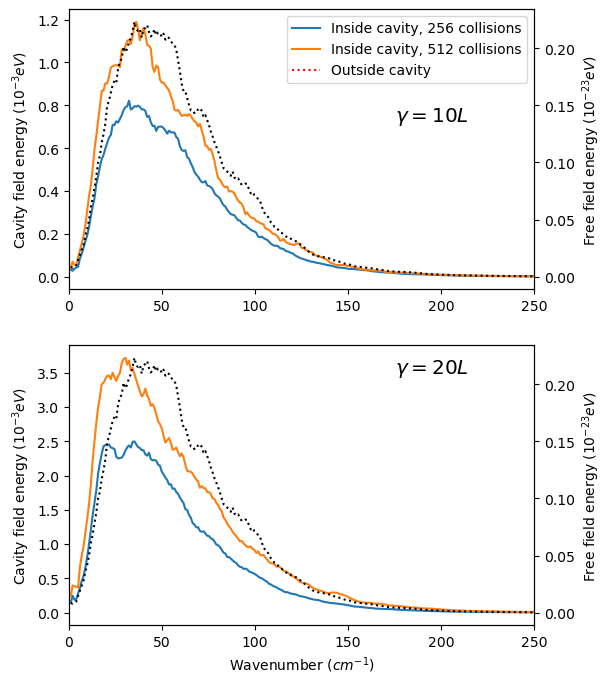

In [7]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {'256':CAVITYFIELD_RESULT_DICT2, '512':CAVITYFIELD_RESULT_DICT512}

fig,ax = plt.subplots(2, figsize = (6,8))

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)
    
            del result_dict
            
            n_pickle += 1
            if n_pickle > 40: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        ax[i].plot(o, f, label = 'Inside cavity, {} collisions'.format(no_collision))
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            
            ax[i].set_xlim(0, 250)
            
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100, rad_profile100, 
                linestyle = linestyle_list[2], color= 'black'
            )
            tax.set_xlim(0, 250)
        
            ax[i].set_ylabel(r"Cavity field energy ($10^{-3} eV$)")
            tax.set_ylabel(r"Free field energy ($10^{-23} eV$)")

ax[0].plot(
    [], [], label = "Outside cavity" , 
    linestyle = linestyle_list[2],color='r'
)

ax[1].set_xlabel(r'Wavenumber ($cm^{-1}$)')

ax[0].annotate(r'$\gamma = 10L$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 20L$',xy = (0.7,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()

fig.savefig(fig_root + "cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


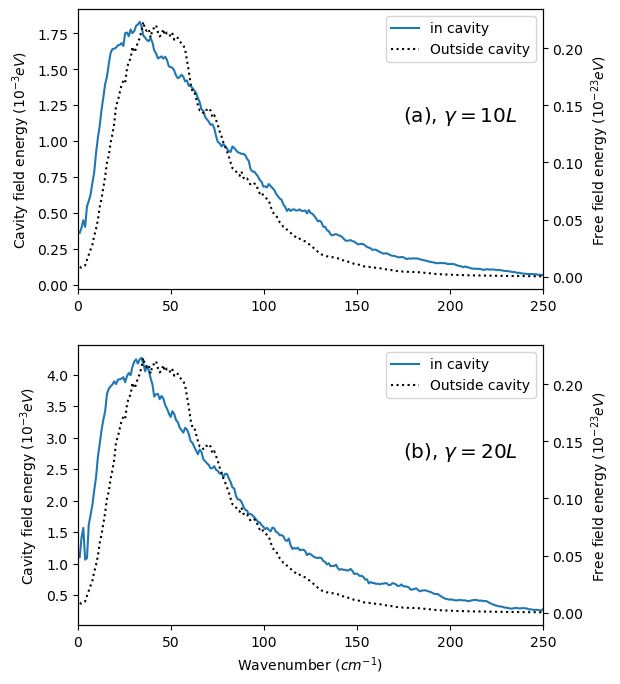

In [6]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

fig,ax = plt.subplots(2, figsize = (6,8))

for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_512b_DICT.items()):
    
    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile1 = []
    rad_profile2 = []
    n_pickle = 0
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        omega_profile, rad_profile = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        
        rad_profile1.append(rad_profile)
        
        del result_dict
        
        n_pickle += 1
        if n_pickle > 40: break

    rad_profile1 = np.mean(rad_profile1, axis = 0) * 1e3
    o, f = moving_average(omega_profile, rad_profile1, w = 10)

    ax[i].plot(o, f, label = 'in cavity')

    tax = ax[i].twinx()
    tax.plot(
        omega_profile100, rad_profile100, 
        linestyle = linestyle_list[2], color= 'black'
    )

    ax[i].plot(
        [], [], label = "Outside cavity" , 
        linestyle = linestyle_list[2],color='black'
    )

    ax[i].set_xlim(0, 250)

    """
    if i == 0:
        ax[i].set_ylim(-0.01, 4.1)
        tax.set_ylim(-0.01, 0.9)
    elif i == 1:
        ax[i].set_ylim(-0.01, 6.5)
        tax.set_ylim(-0.01, 0.72)
    #"""

    ax[i].set_ylabel(r"Cavity field energy ($10^{-3} eV$)")
    tax.set_ylabel(r"Free field energy ($10^{-23} eV$)")
    ax[i].legend()

ax[0].annotate(r'(a), $\gamma = 10L$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'(b), $\gamma = 20L$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')

ax[i].set_xlabel(r'Wavenumber ($cm^{-1}$)')
fig.savefig(fig_root + "boltzmann_cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

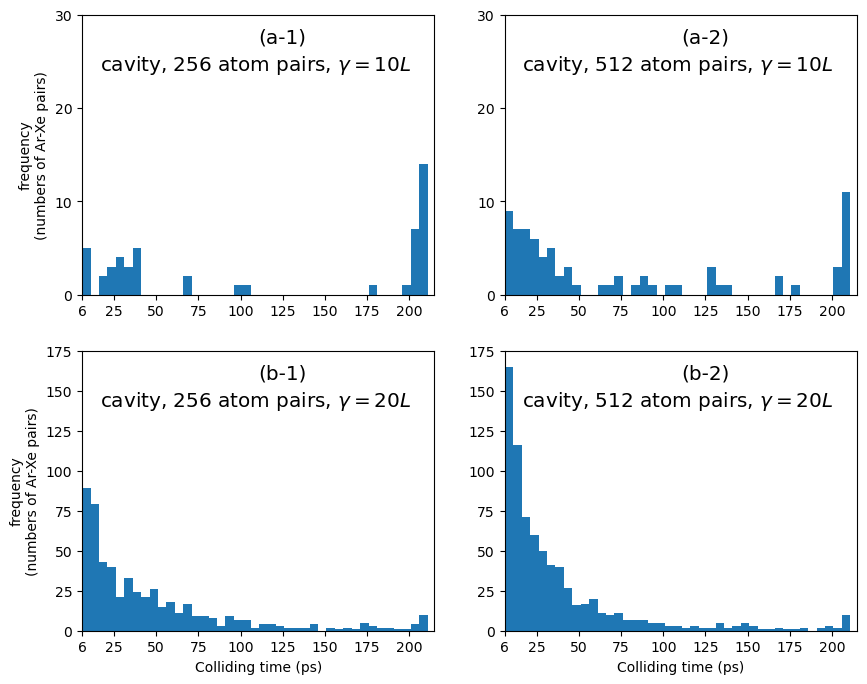

In [8]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(2,2, figsize = (10,8))

foo = [CAVITYFIELD_RESULT_256z_DICT, CAVITYFIELD_RESULT_512z_DICT]

letters = ['a', 'b', 'c']

ct_dict = {}

for j, result_dict in enumerate(foo):
    food = {}
    for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
        
        cavityfield_result_dict = result_dict[coup_str]
        ct = getall_colliding_time(cavityfield_result_dict, limit = 40)
        ct = np.array(ct, dtype = np.float32)
    
        frame = np.arange(5.9999, 214.9999, 4.9999, dtype = np.float32)
        bin2 = ax[i,j].hist(ct, frame)
    
        food.update({coup_str : ct})
        
        del ct
        del cavityfield_result_dict
    
        ax[i,j].yaxis.set_major_formatter('{x:.0f}')
        
        ax[i,j].xaxis.set_major_locator(MultipleLocator(25))
        ax[i,j].set_xticks(list(ax[i,j].get_xticks()) + [6])
        ax[i,j].set_xlim(6,215)
        
        
        if i == 0:
            ax[i,j].set_ylim(0,30)
            ax[i,j].yaxis.set_major_locator(MultipleLocator(10))
            
        elif i == 1:
            ax[i,j].set_ylim(0,175)
            ax[i,j].yaxis.set_major_locator(MultipleLocator(25))

        ax[i,j].annotate(
            '({}-{})'.format(letters[i], j + 1), 
            xy = (0.5,0.9), xycoords = 'axes fraction',
            size = 'x-large', )
    ct_dict.update({j: food})

ax[1,0].set_xlabel('Colliding time (ps)')
ax[1,1].set_xlabel('Colliding time (ps)')
#ax[1,2].set_xlabel('Colliding time (ps)')

ax[0,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')
ax[1,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[0,0].annotate(r'cavity, 256 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,1].annotate(r'cavity, 512 atom pairs, $\gamma = 10L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate(r'cavity, 256 atom pairs, $\gamma = 20L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate(r'cavity, 512 atom pairs, $\gamma = 20L$',xy = (0.05,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

fig.savefig(fig_root + 'histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [76]:
for i, foo in ct_dict.items():
    for coup_str, ct in foo.items():
        print(i, coup_str, np.mean(ct[ct > 6]), len(ct[ct > 6]), len(ct))

0 Lxy1e1 116.73905 50 10240
0 Lxy2e1 52.36257 563 10240
1 Lxy1e1 81.17252 78 10240
1 Lxy2e1 39.841053 753 10240


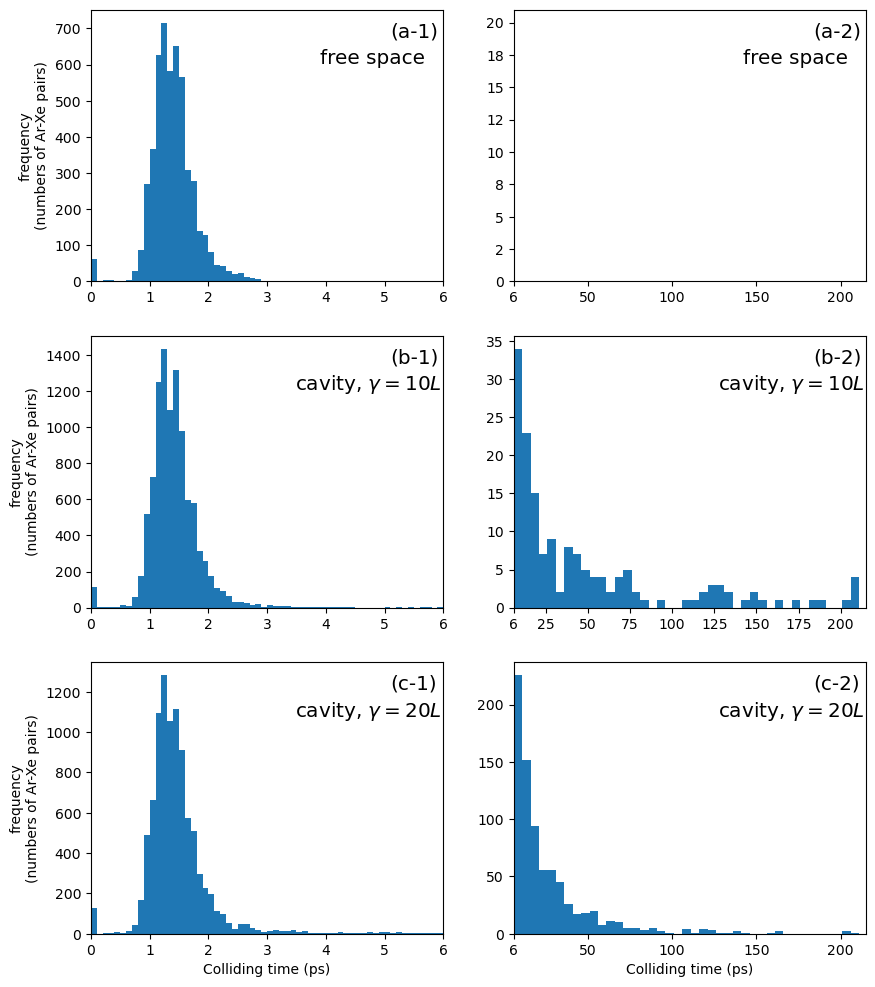

In [9]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(3,2, figsize = (10,12))

bin_dict = {}

ct0 = getall_colliding_time(FREEFIELD_RESULT_256_DICT['100.0'], limit = 0)

bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
    i+= 1
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = 0)

    bin1 = ax[i,0].hist(ct, np.arange(0,6 + 0.1, 0.1))
    bin2 = ax[i,1].hist(ct, np.arange(5.9999,214.9999,4.9999))
    
    bin_dict.update({coup_str: (bin1, bin2)})

    ct_dict2.update({coup_str : ct})
    
    del ct
    del cavityfield_result_dict
        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')

    if i == 0:  
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
    elif i == 1:
        ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(3):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [6])
    ax[i,1].set_xlim(6,215)
    ax[i,0].set_xlim(0,6)
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[2,0].set_xlabel('Colliding time (ps)')
ax[2,1].set_xlabel('Colliding time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,0].annotate('free space',xy = (0.65,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,0].annotate(r'cavity, $\gamma = 10L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,0].annotate('(c-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,0].annotate(r'cavity, $\gamma = 20L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[0,1].annotate('free space',xy = (0.65,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1,1].annotate(r'cavity, $\gamma = 10L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,1].annotate('(c-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[2,1].annotate(r'cavity, $\gamma = 20L$',xy = (0.58,0.8), xycoords = 'axes fraction', fontsize = 'x-large')

fig.savefig(fig_root + 'histogram_boltzmann.jpeg',dpi=600, bbox_inches = 'tight')

In [78]:
for coup_str, ct in ct_dict2.items():
        print(i, coup_str, np.mean(ct[ct > 6]), len(ct[ct > 6]), len(ct))

1 Lxy1e1 48.71199674437858 143 10240
1 Lxy2e1 28.234307067574264 650 10240


In [ ]:
cavityfield_result_dict2 = categorizing_pickle(
    CAVITYFIELD_RESULT_DICT2['Lxy15'], ''
)
with open(cavityfield_result_dict2[1],'rb') as handle:
    cavityfield_result_dict2 = pickle.load(handle)

In [ ]:
atoms = cavityfield_result_dict2['atoms']
coltime = np.array(get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = cavityfield_result_dict2['field']
atoms = cavityfield_result_dict2['atoms']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

In [ ]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
wn_list = red.convert_wavenumber(field.k_val)

In [ ]:
fig,ax = plt.subplots(3,figsize = (8,12))

hem = np.array(field.history['energy'])

t0 = 190; tf = 205
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[0].plot(x, y)
ax[0].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 250; tf = 275
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[1].plot(x,y)
ax[1].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 230; tf = 240
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[2].plot(x,y)
ax[2].vlines(22.766, min(y), max(y), linestyle = 'dotted')


In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = i , N_pairs = N_pairs, save_path = 'figure2/longest_anime')

In [ ]:
for i, (temp, result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):

    if i == 0: continue
    result_dict = categorizing_result(result_path)

    for j in result_dict.keys():
        atoms = result_dict[j]['atoms']
        field = result_dict[j]['field']
    
        k = np.array(atoms.observable['kinetic'])
        v = np.array(atoms.observable['potential'])
        
        hrad = np.sum(field.history['energy'], axis = 1)
        t = field.history['t']
        
        total = k + v + hrad
        print(red.convert_energy(
            (total[0] - total[-1]) / (512*3 + 300 * 2)
            ,'ev'
        ))

In [ ]:
red.convert_energy(1 / (512 * 3 + 300) , 'ev')

In [ ]:
fig,ax = plt.subplots(3, figsize = (6,12))

foo = [5,12,14]

for i, (cs, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    cavityfield_result_dict = categorizing_result(CAVITYFIELD_RESULT_DICT2[cs], '')
    
    wn, spec1 = dipole_spectra(cavityfield_result_dict, 1e-2,time_frame = (5.0, np.inf), windows = 'Gaussian')
    
    #w, s = pt.moving_average(wn_real, spec1, w = 2)
    spec1 = np.mean(spec1, axis = 0)
    spec1 = spec1[wn < 75] * 1e6
    wn = wn[wn < 75]
    ax[i].plot(wn, spec1, label = "T = {} K".format(temp))
    ax[i].vlines(vib_freq, min(spec1), max(spec1), linestyle = 'dotted')
    
    del cavityfield_result_dict

ax[0].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_ylabel("Emission (Arbitrary unit)")
ax[2].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_xlabel("Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "cavity_spectrum_peak.jpeg",dpi = 600,bbox_inches = 'tight')